# Zadanie 15.6

 Dla stworzonego wcześniej Pipeline’a wybierz najlepsze hiperparametry na podstawie podzbiorów walidacyjnych i siatki hiperparametrów (skorzystaj z GridSearch).

##### Załadowanie bibliotek

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score


##### Załadowanie danych

In [2]:
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


##### Podział na `X`, `y`, `cyclical_features`, `nominal_features` i `numeric_features` oraz `train_test_split`

In [3]:
X = bike_data.drop(['rentals'], axis=1).copy()
y = bike_data['rentals'].copy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
cyclical_features = ['season', 'mnth', 'weekday']
nominal_features = ['weathersit', 'holiday', 'workingday']

##### Stworzenie `SineCosineTransformer` i `DifferenceTempTransformer`

In [6]:
class SineCosineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def _get_period(self, X, column):
        return X[column].nunique()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for column in self.columns:
            period = self._get_period(X_transformed, column)
            X_transformed[f'{column}_sin'] = np.sin(2 * np.pi * X_transformed[column] / period)
            X_transformed[f'{column}_cos'] = np.cos(2 * np.pi * X_transformed[column] / period)
        X_transformed.drop(columns=self.columns, inplace=True)
        return X_transformed

In [7]:
class DifferenceTempTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, atemp_col='atemp', temp_col='temp', new_col='difference_temp'):
        self.atemp_col = atemp_col
        self.temp_col = temp_col
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.new_col] = np.where(
            X_transformed[self.temp_col] != 0,
            (X_transformed[self.atemp_col] - X_transformed[self.temp_col]) / X_transformed[self.temp_col],
            0
        )
        X_transformed.drop(columns=[self.atemp_col], inplace=True)
        return X_transformed

##### Stworzenie `Pipeline`

In [8]:
cyclical_features_prep = Pipeline(steps=[
    ('sine_cosine', SineCosineTransformer(columns=cyclical_features))
])

nominal_features_prep = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(drop='first', sparse_output=False))
])

numeric_features_prep = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())
])

data_preparation = ColumnTransformer(transformers=[
    ('cyclical_preprocessing', cyclical_features_prep, cyclical_features),
    ('nominal_preprocessing', nominal_features_prep, nominal_features),
    ('numeric_features', numeric_features_prep, numeric_features)
])

##### Funkcja do ewaluacji modelu

In [9]:
def evaluate_and_visualize(model_name, y_true, y_pred, X_test, results_df, axes):

    # Obliczanie metryk
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Dopisanie wiersza do wspólnego DataFrame
    new_row = {
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae,
        "MAPE": mape
    }
    results_df.loc[len(results_df)] = new_row

    # Rysowanie wykresów
    # Wykres "Actual vs. Predicted"
    axes[0].scatter(y_true, y_pred, alpha=0.7, edgecolor='k', label=model_name)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0].set_xlabel('Actual Values', fontsize=12)
    axes[0].set_ylabel('Predicted Values', fontsize=12)
    axes[0].set_title('Actual vs. Predicted', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Wykres reszt (Residuals vs. Predicted)
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.7, edgecolor='k', label=model_name)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Predicted Values', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_title('Residuals Plot', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Histogram reszt
    axes[2].hist(residuals, bins=20, alpha=0.5, edgecolor='k', label=model_name)
    axes[2].set_xlabel('Residuals', fontsize=12)
    axes[2].set_ylabel('Frequency', fontsize=12)
    axes[2].set_title('Histogram of Residuals', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    return results_df

##### Model z modułu 13.5

Model 13.5
Metrics:
RMSE:  539.9714977428556
R2:  0.40823851956835067


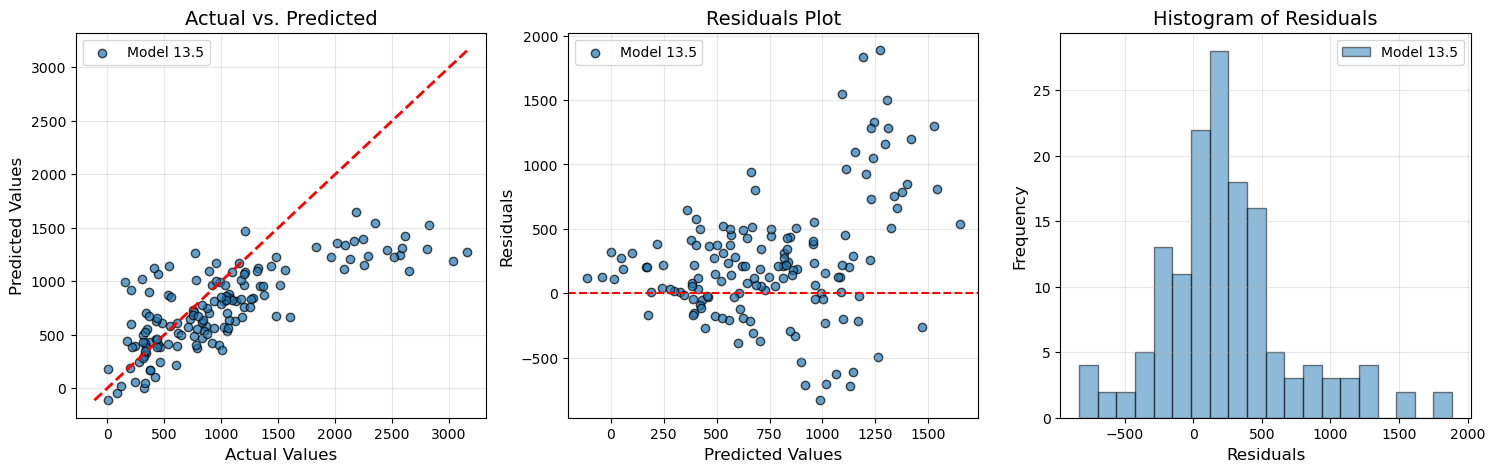

In [10]:
model_13_5 = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.4, random_state=42))
])

# Ustawienie parametru degree=1 w preprocessorze zgodnie z modułem 13.5
model_13_5.set_params(data_preparation__numeric_features__polynomialfeatures__degree=1)

model_13_5.fit(X_train, y_train)

y_pred_model_13_5 = model_13_5.predict(X_test)

print("Model 13.5")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_model_13_5))
print("R2: ", r2_score(y_test, y_pred_model_13_5))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
evaluate_and_visualize("Model 13.5", y_test, y_pred_model_13_5, X_test, results_df, axes)
plt.show()

##### GridSearch dla modelu `ElaticNet`

In [11]:
ElastiNet = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', ElasticNet(random_state=42))
])

ElasticNet_params = {
    # Nominal Features Preprocessing
    'data_preparation__nominal_preprocessing__one_hot_encoder__drop': [None, 'first'],
    'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': [True, False],

    # Numeric Features Preprocessing
    'data_preparation__numeric_features__logtransformer__method': ['yeo-johnson'],
    'data_preparation__numeric_features__standardscaler__with_mean': [True, False],
    'data_preparation__numeric_features__polynomialfeatures__degree': [1, 2, 3],
    'data_preparation__numeric_features__polynomialfeatures__interaction_only': [True, False],

    # Model Parameters (Elastic Net)
    'model__alpha': np.logspace(-4, 1, 50),
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'model__max_iter': [1000, 5000, 10000]
}

# GridSearchCV
ElasticNet_grid_search = GridSearchCV(
    estimator=ElastiNet,
    param_grid=ElasticNet_params,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Dopasowanie modelu
ElasticNet_grid_search.fit(X_train, y_train)

# Wyniki GridSearchCV
print("Najlepsze parametry:", ElasticNet_grid_search.best_params_)
print("=" * 15)
print("Najlepszy wynik MSE:", -ElasticNet_grid_search.best_score_)
print("Najlepszy wynik RMSE:", np.sqrt(-ElasticNet_grid_search.best_score_))

Fitting 5 folds for each of 43200 candidates, totalling 216000 fits
Najlepsze parametry: {'data_preparation__nominal_preprocessing__one_hot_encoder__drop': None, 'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': True, 'data_preparation__numeric_features__logtransformer__method': 'yeo-johnson', 'data_preparation__numeric_features__polynomialfeatures__degree': 3, 'data_preparation__numeric_features__polynomialfeatures__interaction_only': False, 'data_preparation__numeric_features__standardscaler__with_mean': False, 'model__alpha': 1.9306977288832496, 'model__l1_ratio': 1.0, 'model__max_iter': 1000}
Najlepszy wynik MSE: 209730.53637311287
Najlepszy wynik RMSE: 457.9634661991204


c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.039e+04, tolerance: 2.675e+04
  model = cd_fast.enet_coordinate_descent(


c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.039e+04, tolerance: 2.675e+04
  model = cd_fast.enet_coordinate_descent(


Model ElasticNet
Metrics:
RMSE:  458.9028131309384
R2:  0.5725882477036373


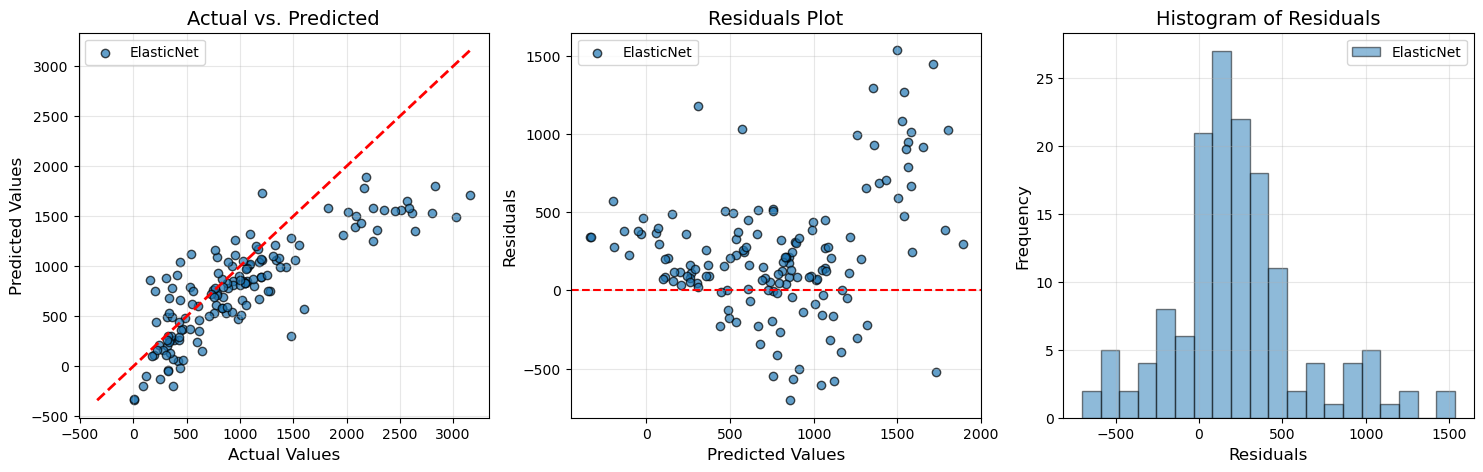

In [12]:
ElasticNet_grid_search.best_estimator_.fit(X_train, y_train)

y_pred_ElasticNet_best_model = ElasticNet_grid_search.best_estimator_.predict(X_test)

print("Model ElasticNet")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_ElasticNet_best_model))
print("R2: ", r2_score(y_test, y_pred_ElasticNet_best_model))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df = evaluate_and_visualize("ElasticNet", y_test, y_pred_ElasticNet_best_model, X_test, results_df, axes)
plt.show()

##### GridSearch dla modelu `XGBoost`

In [13]:
XGBoost = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', XGBRegressor(random_state=42))
])

XGBoost_params = {
    # Nominal Features Preprocessing
    'data_preparation__nominal_preprocessing__one_hot_encoder__drop': [None, 'first'],
    'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': [True, False],

    # Numeric Features Preprocessing
    'data_preparation__numeric_features__logtransformer__method': ['yeo-johnson'],
    'data_preparation__numeric_features__standardscaler__with_mean': [True, False],
    'data_preparation__numeric_features__polynomialfeatures__degree': [1, 2, 3],
    'data_preparation__numeric_features__polynomialfeatures__interaction_only': [True, False],

    # Model Parameters (XGBoost)
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0]
}

# GridSearchCV
XGBoost_grid_search = GridSearchCV(
    estimator=XGBoost,
    param_grid=XGBoost_params,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Dopasowanie modelu
XGBoost_grid_search.fit(X_train, y_train)

# Wyniki
print("Najlepsze parametry:", XGBoost_grid_search.best_params_)
print("Najlepszy wynik MSE:", -XGBoost_grid_search.best_score_)
print("Najlepszy wynik RMSE:", np.sqrt(-XGBoost_grid_search.best_score_))

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Najlepsze parametry: {'data_preparation__nominal_preprocessing__one_hot_encoder__drop': None, 'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': True, 'data_preparation__numeric_features__logtransformer__method': 'yeo-johnson', 'data_preparation__numeric_features__polynomialfeatures__degree': 2, 'data_preparation__numeric_features__polynomialfeatures__interaction_only': True, 'data_preparation__numeric_features__standardscaler__with_mean': True, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
Najlepszy wynik MSE: 182378.717776119
Najlepszy wynik RMSE: 427.05821356826635


Model XGBoost
Metrics:
RMSE:  369.71647375174075
R2:  0.7225768566131592


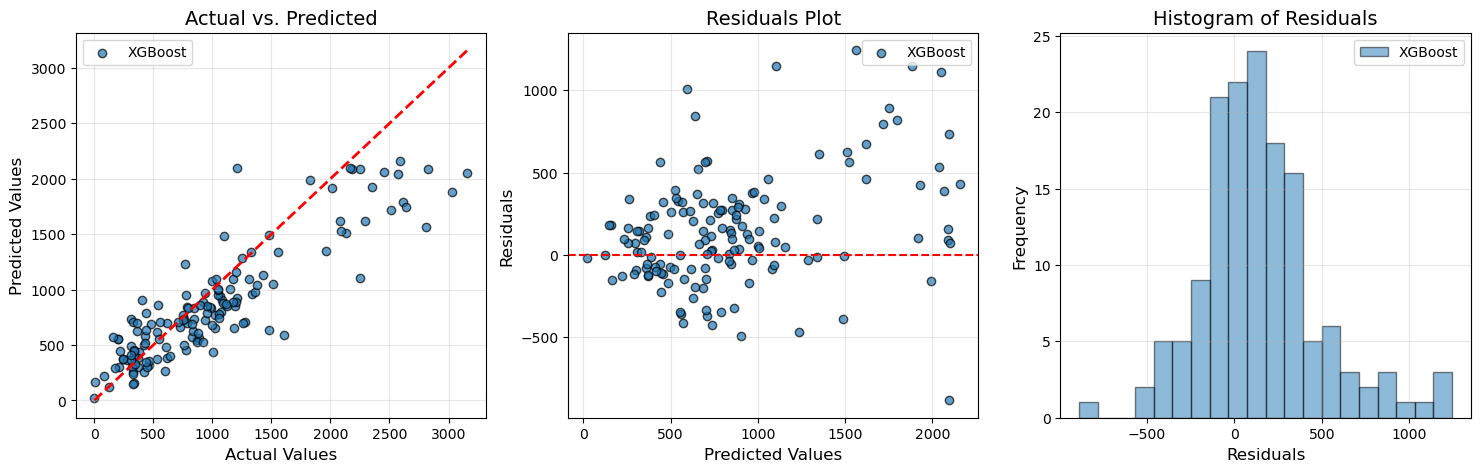

In [14]:
XGBoost_grid_search.best_estimator_.fit(X_train, y_train)

y_pred_best_XGBoost = XGBoost_grid_search.best_estimator_.predict(X_test)

print("Model XGBoost")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_best_XGBoost))
print("R2: ", r2_score(y_test, y_pred_best_XGBoost))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df = evaluate_and_visualize("XGBoost", y_test, y_pred_best_XGBoost, X_test, results_df, axes)
plt.show()

##### GridSearch dla modelu `SVR`

In [16]:
paramsSVR = {

    # Nominal Features Preprocessing
    'data_preparation__nominal_preprocessing__one_hot_encoder__drop': [None, 'first'],
    'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': [True, False],

    # Numeric Features Preprocessing
    'data_preparation__numeric_features__logtransformer__method': ['yeo-johnson'],
    'data_preparation__numeric_features__standardscaler__with_mean': [True, False],
    'data_preparation__numeric_features__polynomialfeatures__degree': [1, 2, 3],
    'data_preparation__numeric_features__polynomialfeatures__interaction_only': [True, False],

    # Model Parameters (SVR)
    'model__degree': [2, 3, 4],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto']
}

modelSVR = SVR()

SVR_pipeline = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', modelSVR)
])

SVR_grid_search = GridSearchCV(
    estimator=SVR_pipeline,
    param_grid=paramsSVR,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

SVR_grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", SVR_grid_search.best_params_)
print("Najlepszy wynik MSE:", -SVR_grid_search.best_score_)
print("Najlepszy wynik RMSE:", np.sqrt(-SVR_grid_search.best_score_))

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Najlepsze parametry: {'data_preparation__nominal_preprocessing__one_hot_encoder__drop': None, 'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': True, 'data_preparation__numeric_features__logtransformer__method': 'yeo-johnson', 'data_preparation__numeric_features__polynomialfeatures__degree': 3, 'data_preparation__numeric_features__polynomialfeatures__interaction_only': False, 'data_preparation__numeric_features__standardscaler__with_mean': True, 'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Najlepszy wynik MSE: 248041.0352077803
Najlepszy wynik RMSE: 498.0371825554597


Model SVR
Metrics:
RMSE:  532.6251156294016
R2:  0.4242309678484302


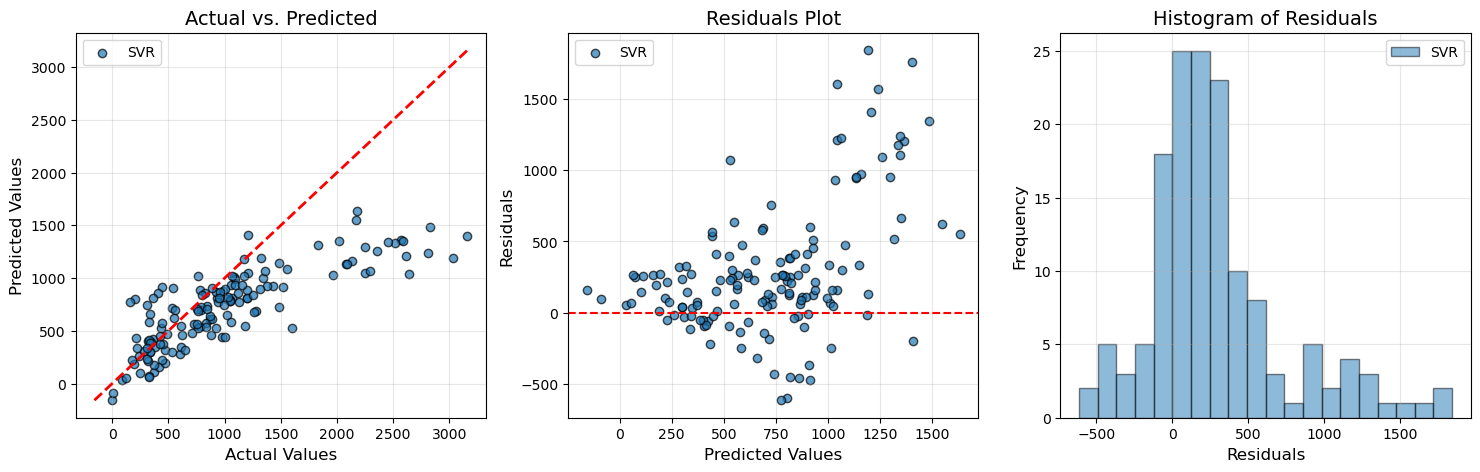

In [17]:
SVR_grid_search.best_estimator_.fit(X_train, y_train)

y_pred_best_SVR = SVR_grid_search.best_estimator_.predict(X_test)

print("Model SVR")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_best_SVR))
print("R2: ", r2_score(y_test, y_pred_best_SVR))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df = evaluate_and_visualize("SVR", y_test, y_pred_best_SVR, X_test, results_df, axes)
plt.show()

##### GridSearch dla modelu `KNeighborsRegressor`

In [19]:
KNNparams = {

    # Nominal Features Preprocessing
    'data_preparation__nominal_preprocessing__one_hot_encoder__drop': [None, 'first'],
    'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': [True, False],

    # Numeric Features Preprocessing
    'data_preparation__numeric_features__logtransformer__method': ['yeo-johnson'],
    'data_preparation__numeric_features__standardscaler__with_mean': [True, False],
    'data_preparation__numeric_features__polynomialfeatures__degree': [1, 2, 3],
    'data_preparation__numeric_features__polynomialfeatures__interaction_only': [True, False],

    # Model Parameters (KNeighborsRegressor)
    'model__n_neighbors': [3, 5, 10],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

KNNmodel = KNeighborsRegressor()

KNN_pipeline = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', KNNmodel)
])

KNN_grid_search = GridSearchCV(
    estimator=KNN_pipeline,
    param_grid=KNNparams,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

KNN_grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", KNN_grid_search.best_params_)
print("Najlepszy wynik MSE:", -KNN_grid_search.best_score_)
print("Najlepszy wynik RMSE:", np.sqrt(-KNN_grid_search.best_score_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Najlepsze parametry: {'data_preparation__nominal_preprocessing__one_hot_encoder__drop': None, 'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': True, 'data_preparation__numeric_features__logtransformer__method': 'yeo-johnson', 'data_preparation__numeric_features__polynomialfeatures__degree': 2, 'data_preparation__numeric_features__polynomialfeatures__interaction_only': True, 'data_preparation__numeric_features__standardscaler__with_mean': True, 'model__n_neighbors': 10, 'model__p': 1, 'model__weights': 'distance'}
Najlepszy wynik MSE: 197572.1426894654
Najlepszy wynik RMSE: 444.4908803220437


Model KNN
Metrics:
RMSE:  432.61307808382384
R2:  0.6201568419911615


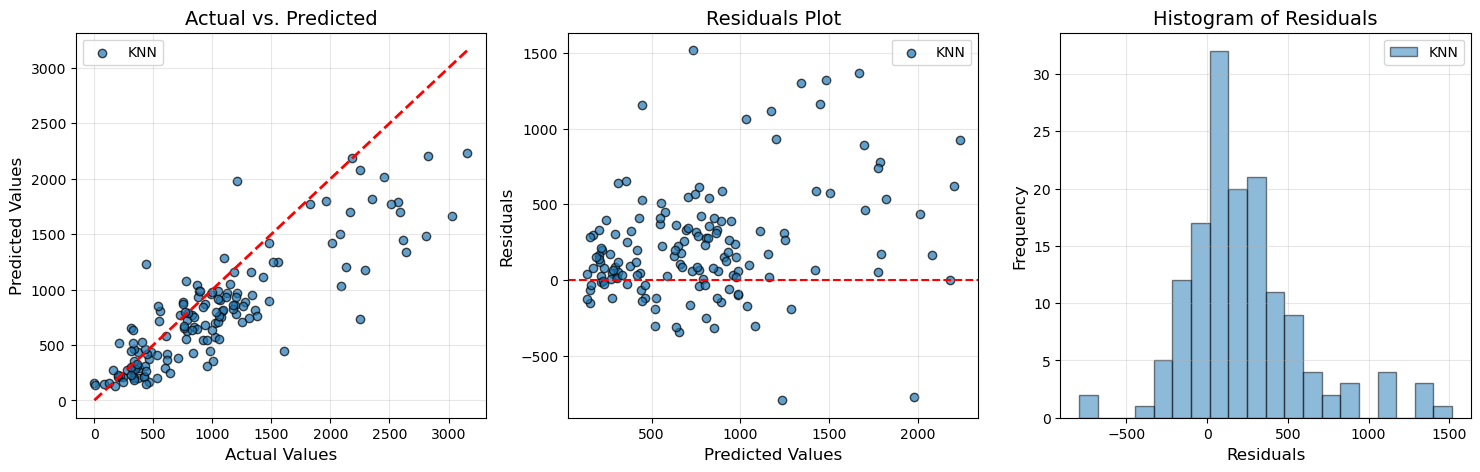

In [20]:
KNN_grid_search.best_estimator_.fit(X_train, y_train)

y_pred_best_KNN = KNN_grid_search.best_estimator_.predict(X_test)

print("Model KNN")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_best_KNN))
print("R2: ", r2_score(y_test, y_pred_best_KNN))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df = evaluate_and_visualize("KNN", y_test, y_pred_best_KNN, X_test, results_df, axes)
plt.show()

##### GridSearchCV dla modelu `RandomForestRegressor`

In [21]:
RFparams = {

    # Nominal Features Preprocessing
    'data_preparation__nominal_preprocessing__one_hot_encoder__drop': [None, 'first'],
    'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': [True, False],

    # Numeric Features Preprocessing
    'data_preparation__numeric_features__logtransformer__method': ['yeo-johnson'],
    'data_preparation__numeric_features__standardscaler__with_mean': [True, False],
    'data_preparation__numeric_features__polynomialfeatures__degree': [1, 2, 3],
    'data_preparation__numeric_features__polynomialfeatures__interaction_only': [True, False],

    # Model Parameters (RandomForestRegressor)
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2']
}

RFmodel = RandomForestRegressor(random_state=42)

RF_pipeline = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', RFmodel)
])

RF_grid_search = GridSearchCV(
    estimator=RF_pipeline,
    param_grid=RFparams,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

RF_grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", RF_grid_search.best_params_)
print("Najlepszy wynik MSE:", -RF_grid_search.best_score_)
print("Najlepszy wynik RMSE:", np.sqrt(-RF_grid_search.best_score_))

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Najlepsze parametry: {'data_preparation__nominal_preprocessing__one_hot_encoder__drop': None, 'data_preparation__nominal_preprocessing__one_hot_encoder__sparse_output': True, 'data_preparation__numeric_features__logtransformer__method': 'yeo-johnson', 'data_preparation__numeric_features__polynomialfeatures__degree': 3, 'data_preparation__numeric_features__polynomialfeatures__interaction_only': False, 'data_preparation__numeric_features__standardscaler__with_mean': True, 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Najlepszy wynik MSE: 176282.16565517936
Najlepszy wynik RMSE: 419.85969758382305


Model RandomForest
Metrics:
RMSE:  398.6990323811466
R2:  0.6773769572098558


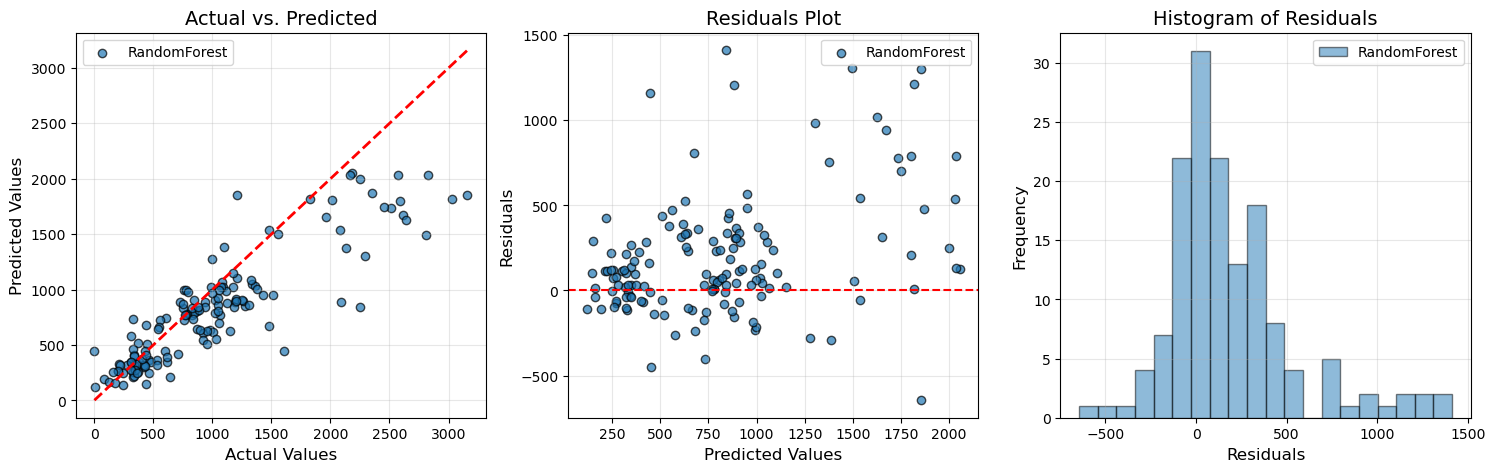

In [22]:
RF_grid_search.best_estimator_.fit(X_train, y_train)

y_pred_best_RF = RF_grid_search.best_estimator_.predict(X_test)

print("Model RandomForest")
print("=" * 15)
print("Metrics:")
print("RMSE: ", root_mean_squared_error(y_test, y_pred_best_RF))
print("R2: ", r2_score(y_test, y_pred_best_RF))

results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df = evaluate_and_visualize("RandomForest", y_test, y_pred_best_RF, X_test, results_df, axes)
plt.show()

##### Wyświetlenie zbiorczych wyników dla wszystkich modeli:

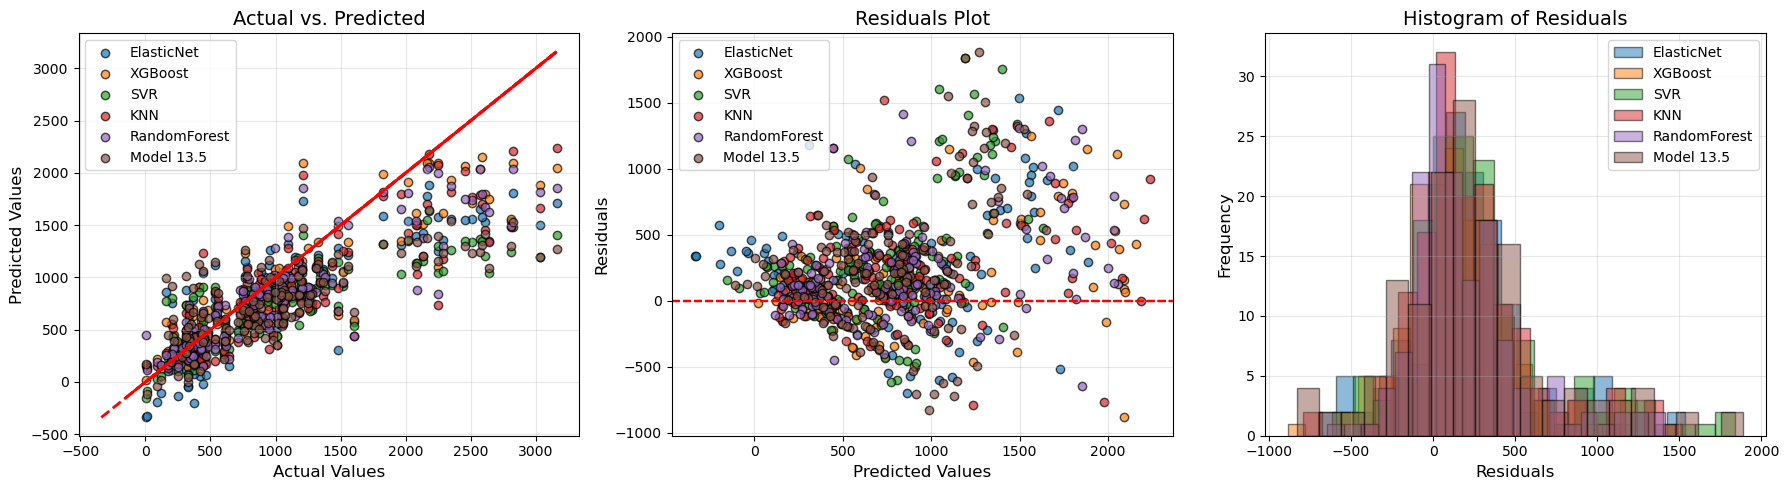

,Model,MSE,RMSE,R2,MAE,MAPE
5,Model 13.5,291569.218375,539.971498,0.408239,386.365644,114.071299
2,SVR,283689.513799,532.625116,0.424231,364.500208,99.850356
0,ElasticNet,210591.791899,458.902813,0.572588,336.042478,185.252138
3,KNN,187154.075329,432.613078,0.620157,301.320989,91.553645
4,RandomForest,158960.918422,398.699032,0.677377,264.672218,186.347218
1,XGBoost,136690.270963,369.716474,0.722577,266.778469,50.759810


In [23]:
results_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2", "MAE", "MAPE"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_df = evaluate_and_visualize("ElasticNet", y_test, y_pred_ElasticNet_best_model, X_test, results_df, axes)
results_df = evaluate_and_visualize("XGBoost", y_test, y_pred_best_XGBoost, X_test, results_df, axes)
results_df = evaluate_and_visualize("SVR", y_test, y_pred_best_SVR, X_test, results_df, axes)
results_df = evaluate_and_visualize("KNN", y_test, y_pred_best_KNN, X_test, results_df, axes)
results_df = evaluate_and_visualize("RandomForest", y_test, y_pred_best_RF, X_test, results_df, axes)
results_df = evaluate_and_visualize("Model 13.5", y_test, y_pred_model_13_5, X_test, results_df, axes)

plt.tight_layout()
plt.show()

display(results_df.sort_values(by='R2'))

##### Wnioski:

Pomysł na dodatkowy podział cech okazał się dobry - model `ElasticNet` wykazał się dzięki temu lepszymi wynikami w GridSearch niż jego protoplasta z modułu 13.5 gdzie tam model osiągał RMSE na poziomie 483. Tu oczywiście wypadł gorzej bo parametry znalezione w GridSearch w module 13.5 miały cechy podzielone tylko na numeryczne i kategoryczne, a ja zastosowałem podział na numeryczne, nominalne i cykliczne. Najlepszym ze wszystkich modeli okazał się `XGBoost` i to właśnie nad nim pracowałbym dalej tuningując parametry. Przetestowałbym także modele do niego podobne, takie jak `LightGBM` i `CatBoost`. Umieszczanie wszystkich modeli na jednym plocie to jednak overkill. ;-) Jest to mało czytelne i wizualizacje lepiej prezentują się na osobnych wykresach, które znajdują się pod konkretnymi modelami - dobra lekcja na przyszłość.